# Import Libraries

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import time,pickle

/Users/siddharthnayak/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


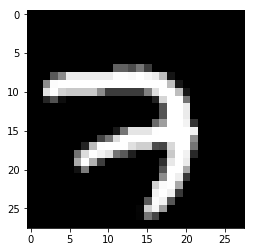

In [2]:
plt.imshow(np.reshape(mnist.train.images[0],(28,28)),cmap='gray')
plt.show()

# The Generator Function
 The function `generator(z)` takes 256-dimensional vector and returns 784-dimensional vector, which is MNIST image (28x28). z here is the prior for the $G(Z)$. In a way it learns a mapping between the prior space to $P_{data}$.

In [18]:
#G(z)
def generator(x):
    '''
    The generator network with a vanilla Neural Net with 2 hidden layers
    '''
    w_init = tf.truncated_normal_initializer(mean=0,stddev=0.02)
    b_init = tf.constant_initializer(0.)
    
    #layer 1
    w_0 = tf.get_variable('Gen_w0',[x.get_shape()[1],256],initializer=w_init)
    b_0 = tf.get_variable('Gen_b0',[256],initializer=b_init)
    h_0 = tf.nn.relu(tf.matmul(x,w_0)+b_0)
    
    #layer 2
    w_1 = tf.get_variable('Gen_w1',[h_0.get_shape()[1],512],initializer=w_init)
    b_1 = tf.get_variable('Gen_b1',[512],initializer=b_init)
    h_1 = tf.nn.relu(tf.matmul(h_0,w_1)+b_1)
    
    #layer 3
    w_2 = tf.get_variable('Gen_w2',[h_1.get_shape()[1],1024],initializer=w_init)
    b_2 = tf.get_variable('Gen_b2',[1024],initializer=b_init)
    h_2 = tf.nn.relu(tf.matmul(h_1,w_2)+b_2)
    
    #output
    w_3 = tf.get_variable('Gen_w3',[h_2.get_shape()[1],784],initializer=w_init)
    b_3 = tf.get_variable('Gen_b3',[784],initializer=b_init)
    out = tf.nn.tanh(tf.matmul(h_2,w_3)+b_3)
    
    return out
    
    

# The Discriminator Function
This takes in an image and gives out the probability of a real MNIST image.

In [19]:
#D(z)
def discriminator(x,drop_out):
    '''
    The discriminator network with a vanilla Neural Net with 3 hidden layers
    This beast produces the output prediction which may be given as a feed back 
    to the Generator network to train.
    '''
    w_init = tf.truncated_normal_initializer(mean=0,stddev=0.02)
    b_init = tf.constant_initializer(0.)
    
    #layer 1
    w_0 = tf.get_variable('Dis_w0',[x.get_shape()[1],1024],initializer=w_init)
    b_0 = tf.get_variable('Dis_b0',[1024],initializer=b_init)
    h_0 = tf.nn.relu(tf.matmul(x,w_0)+b_0)
    h_0 = tf.nn.dropout(h_0, drop_out)
    
    #layer 2
    w_1 = tf.get_variable('Dis_w1',[h_0.get_shape()[1],512],initializer=w_init)
    b_1 = tf.get_variable('Dis_b1',[512],initializer=b_init)
    h_1 = tf.nn.relu(tf.matmul(h_0,w_1)+b_1)
    h_1 = tf.nn.dropout(h_1, drop_out)
    
    #layer 3
    w_2 = tf.get_variable('Dis_w2',[h_1.get_shape()[1],256],initializer=w_init)
    b_2 = tf.get_variable('Dis_b2',[256],initializer=b_init)
    h_2 = tf.nn.relu(tf.matmul(h_1,w_2)+b_2)
    h_2 = tf.nn.dropout(h_2, drop_out)
    
    #output
    w_3 = tf.get_variable('Dis_w3',[h_2.get_shape()[1],1],initializer=w_init)
    b_3 = tf.get_variable('Dis_b3',[1],initializer=b_init)
    out = tf.nn.sigmoid(tf.matmul(h_2,w_3)+b_3) #sigmoid because we want probability and 
    #sigmoid can be interpretated as a probability
    
    return out
    
    

# Function to show the image

In [5]:
def show(num_epoch,show=False,save=False,path='/Users/siddharthnayak/Downloads/GAN/result.png'):
    z_ = np.random.normal(0, 1, (25, 100))
    test_img = sess.run(G_z,{z:z_,drop_out:0.0})
    size_figure_grid = 5
    
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_img[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [6]:
def show_training_hist(hist, show = False, save = False, path = '/Users/siddharthnayak/Downloads/GAN/train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['Dis_losses']
    y2 = hist['Gen_losses']

    plt.plot(x, y1, label='Dis_loss')
    plt.plot(x, y2, label='Gen_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [7]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 100
eps=1e-2

In [8]:
def normalize(t_set):
    return (t_set-0.5)/0.5

train_set = normalize(mnist.train.images)

In [9]:
# for plotting on tensorboard 
with tf.variable_scope('Generator_net') as scope1:
    z = tf.placeholder(tf.float32, shape=(None, 100))
    G_z = generator(z) #call the generator function
    

In [10]:
with tf.variable_scope('Discriminator_net') as scope:
    drop_out = tf.placeholder(dtype = tf.float32,name='Drop_out')
    x = tf.placeholder(tf.float32, shape=(None, 784))
    D_real = discriminator(x,drop_out)
    scope.reuse_variables() #because i am lazy to write it again
    D_fake = discriminator(G_z,drop_out)
#here D_fake means D(G(z)) and D_real means D(z)

# The main equation in GAN :p
$\underset{G}{min}\underset{D}{max}V(D,G) = \mathbb{E}_{x\sim{p_{data}(x)}} [log D(x)]+\mathbb{E}_{z\sim{p_z(z)}} [log(1-D(G(x)))]$<br/>
The algorithm for the updates can be found in the paper by Ian Goodfellow,et al. NIPS 2014

In [11]:
# loss 
Dis_loss = tf.reduce_mean(-tf.log(D_real+eps)-tf.log(1-D_fake+eps))
Gen_loss = tf.reduce_mean(-tf.log(D_fake+eps))

In [12]:
# trainable variables for each network
t_vars = tf.trainable_variables()
Dis_vars = [var for var in t_vars if 'Dis_' in var.name]
Gen_vars = [var for var in t_vars if 'Gen_' in var.name]

In [13]:
# optimizer for each network
Dis_optim = tf.train.AdamOptimizer(lr).minimize(Dis_loss, var_list=Dis_vars)
Gen_optim = tf.train.AdamOptimizer(lr).minimize(Gen_loss, var_list=Gen_vars)


In [14]:
# results save folder
if not os.path.isdir('/Users/siddharthnayak/Downloads/GAN'):
    os.mkdir('/Users/siddharthnayak/Downloads/GAN')
if not os.path.isdir('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results'):
    os.mkdir('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results')
if not os.path.isdir('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/Random_results'):
    os.mkdir('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/Random_results')
if not os.path.isdir('/Users/siddharthnayak/Downloads/GAn/MNIST_GAN_results/Fixed_results'):
    os.mkdir('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/Fixed_results')

In [15]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [16]:
#iitialize a dict for training history
train_hist = {}
train_hist['Dis_losses'] = []
train_hist['Gen_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

In [21]:
#training time (finally)
np.random.seed(int(time.time()))
start_time = time.time()
for epoch in range(train_epoch):
    print('Starting epoch %d'%epoch)
    Gen_losses = []
    Dis_losses = []
    epoch_start_time = time.time()
    for iter in range(train_set.shape[0] // batch_size):
        if iter%100==0:
            print(iter)
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]#get next batch
        z_ = np.random.normal(0, 1, (batch_size, 100))
        
        loss_dis,_ = sess.run([Dis_loss, Dis_optim],{x: x_, z: z_, drop_out: 0.3})#evaluate the loss
        Dis_losses.append(loss_dis)
        
        loss_gen,_=sess.run([Gen_loss, Gen_optim],{z:z_,drop_out:0.3})#evaluate the loss
        Gen_losses.append(loss_gen)
        
        
    #print info about each epoch
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_dis: %.3f, loss_gen: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(Dis_losses), np.mean(Gen_losses)))
    p = '/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    fixed_p = '/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    show((epoch + 1), save=True, path=p)
    show((epoch + 1), save=True, path=fixed_p)
    train_hist['Dis_losses'].append(np.mean(Dis_losses))
    train_hist['Gen_losses'].append(np.mean(Gen_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
    
end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
show_train_hist(train_hist, save=True, path='MNIST_GAN_results/MNIST_GAN_train_hist.png')

images = []
for e in range(train_epoch):
    img_name = '/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('/Users/siddharthnayak/Downloads/GAN/MNIST_GAN_results/generation_animation.gif', images, fps=5)

sess.close()

Starting epoch 0
0


KeyboardInterrupt: 